In [1]:
import os
from pprint import pprint
import sys

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks, hilbert
import pickle
import ipywidgets as widgets

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader, plotter, misc, performer
from sleeprnn.detection import metrics, det_utils, ensemble
from figs_thesis import fig_utils
from baselines_scripts.butils import get_partitions
from sleeprnn.detection.feeder_dataset import FeederDataset
from sklearn.linear_model import LinearRegression, HuberRegressor
from sleeprnn.data import utils, stamp_correction

RESULTS_PATH = os.path.join(project_root, 'results')
BASELINES_PATH = os.path.join(project_root, 'resources', 'comparison_data', 'baselines_2021')

%matplotlib inline
viz.notebook_full_width()

param_filtering_fn = fig_utils.get_filtered_signal_for_event
param_frequency_fn = fig_utils.get_frequency_by_fft
param_amplitude_fn = fig_utils.get_amplitude_event

In [2]:
# to use spanish convention in numbers
import locale

locale.setlocale(locale.LC_ALL, "")
plt.rcParams['axes.formatter.use_locale'] = True

In [62]:
model_version = constants.V2_TIME
print_model_names = {
    constants.V2_TIME: '\\textbf{REDv2-Time}',
}

eval_configs = [
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_KC_NAME, expert=1, strategy='5cv', seeds=3),
]


Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}


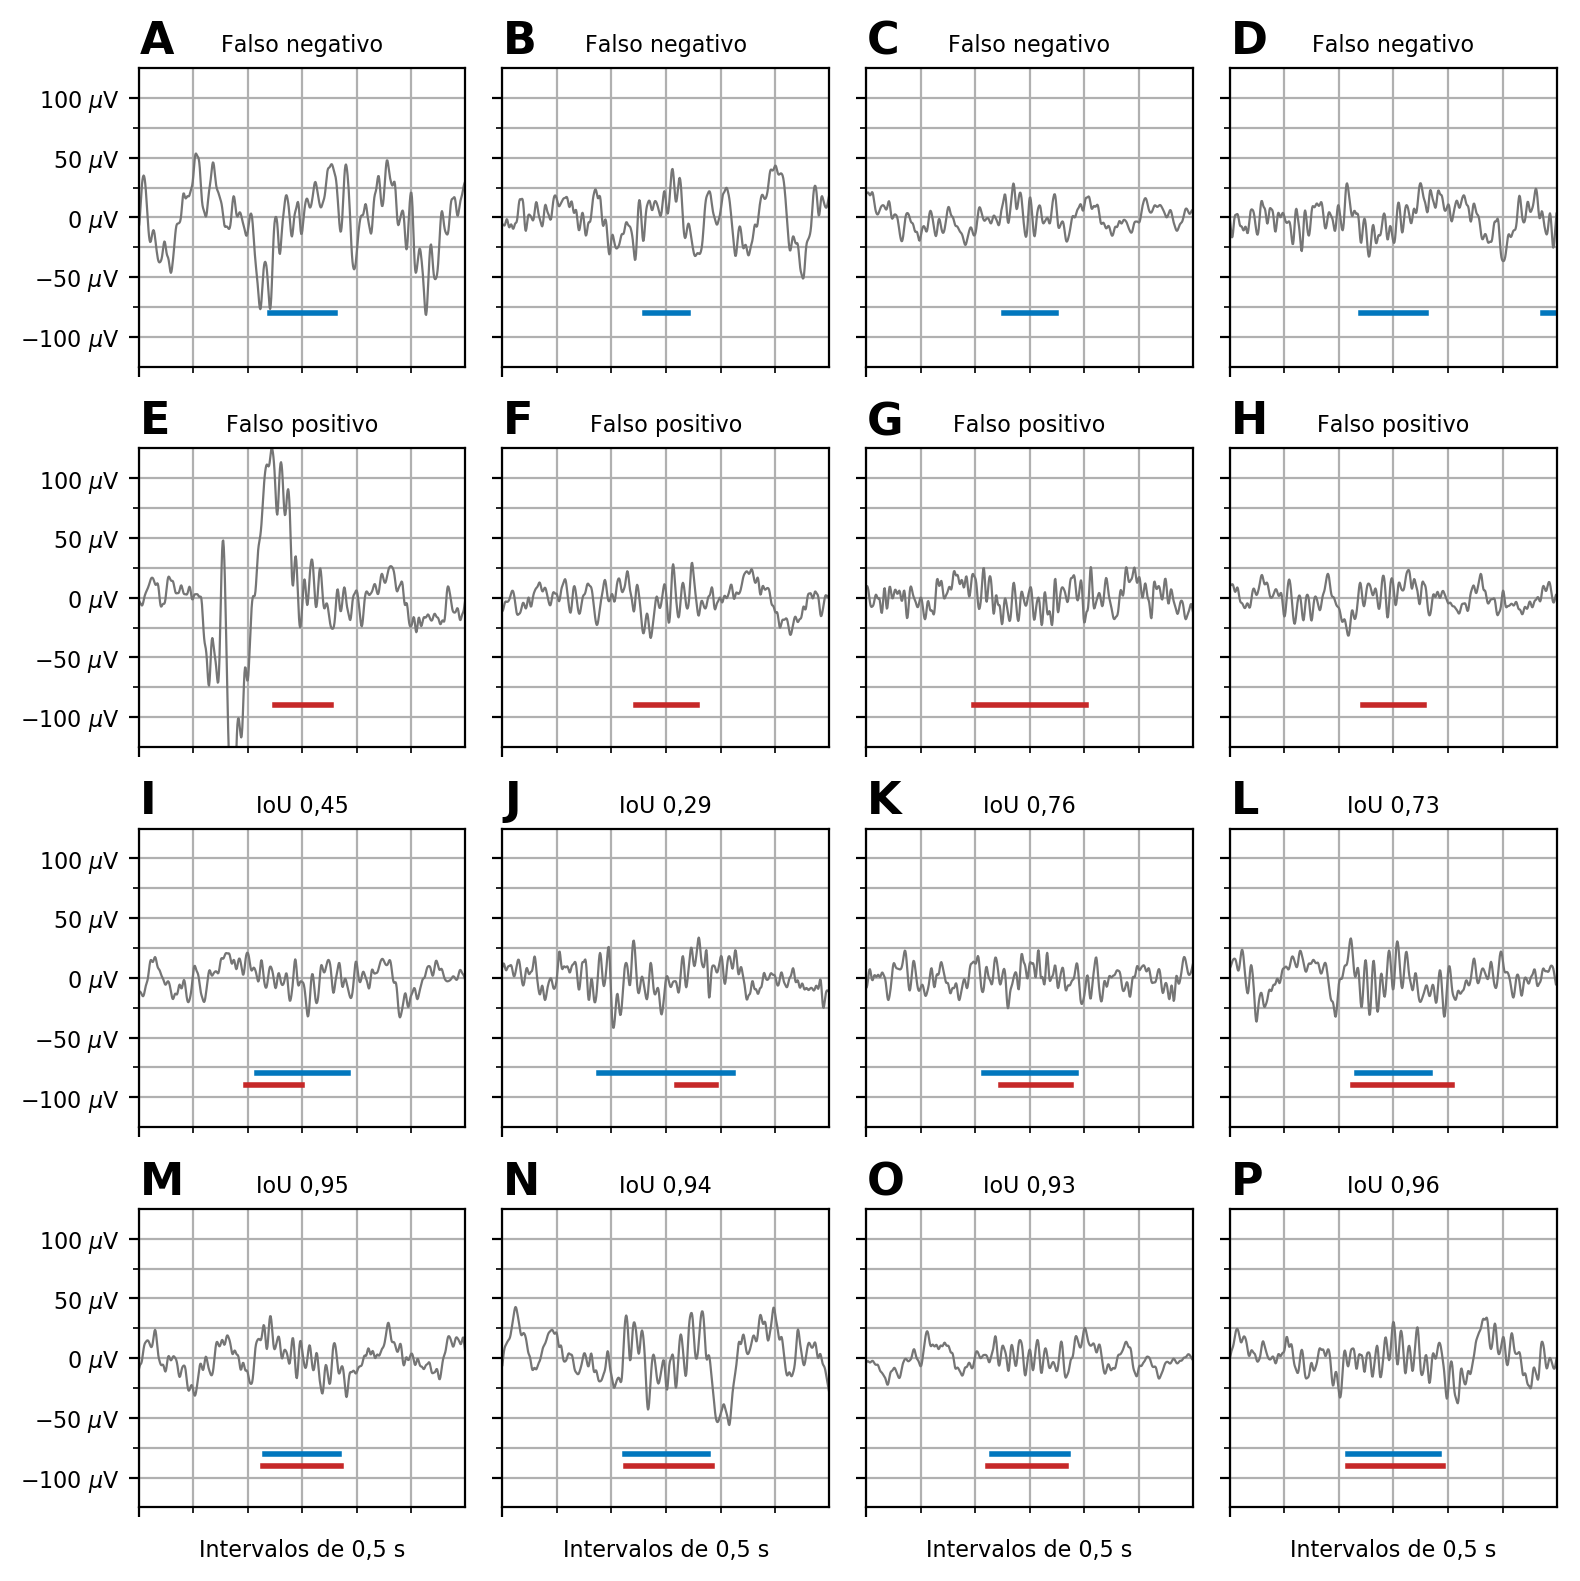


Loading {'dataset_name': 'mass_kc', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
Creating cache that does not exist


/Users/nicolasigor/miniconda3/envs/tf/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


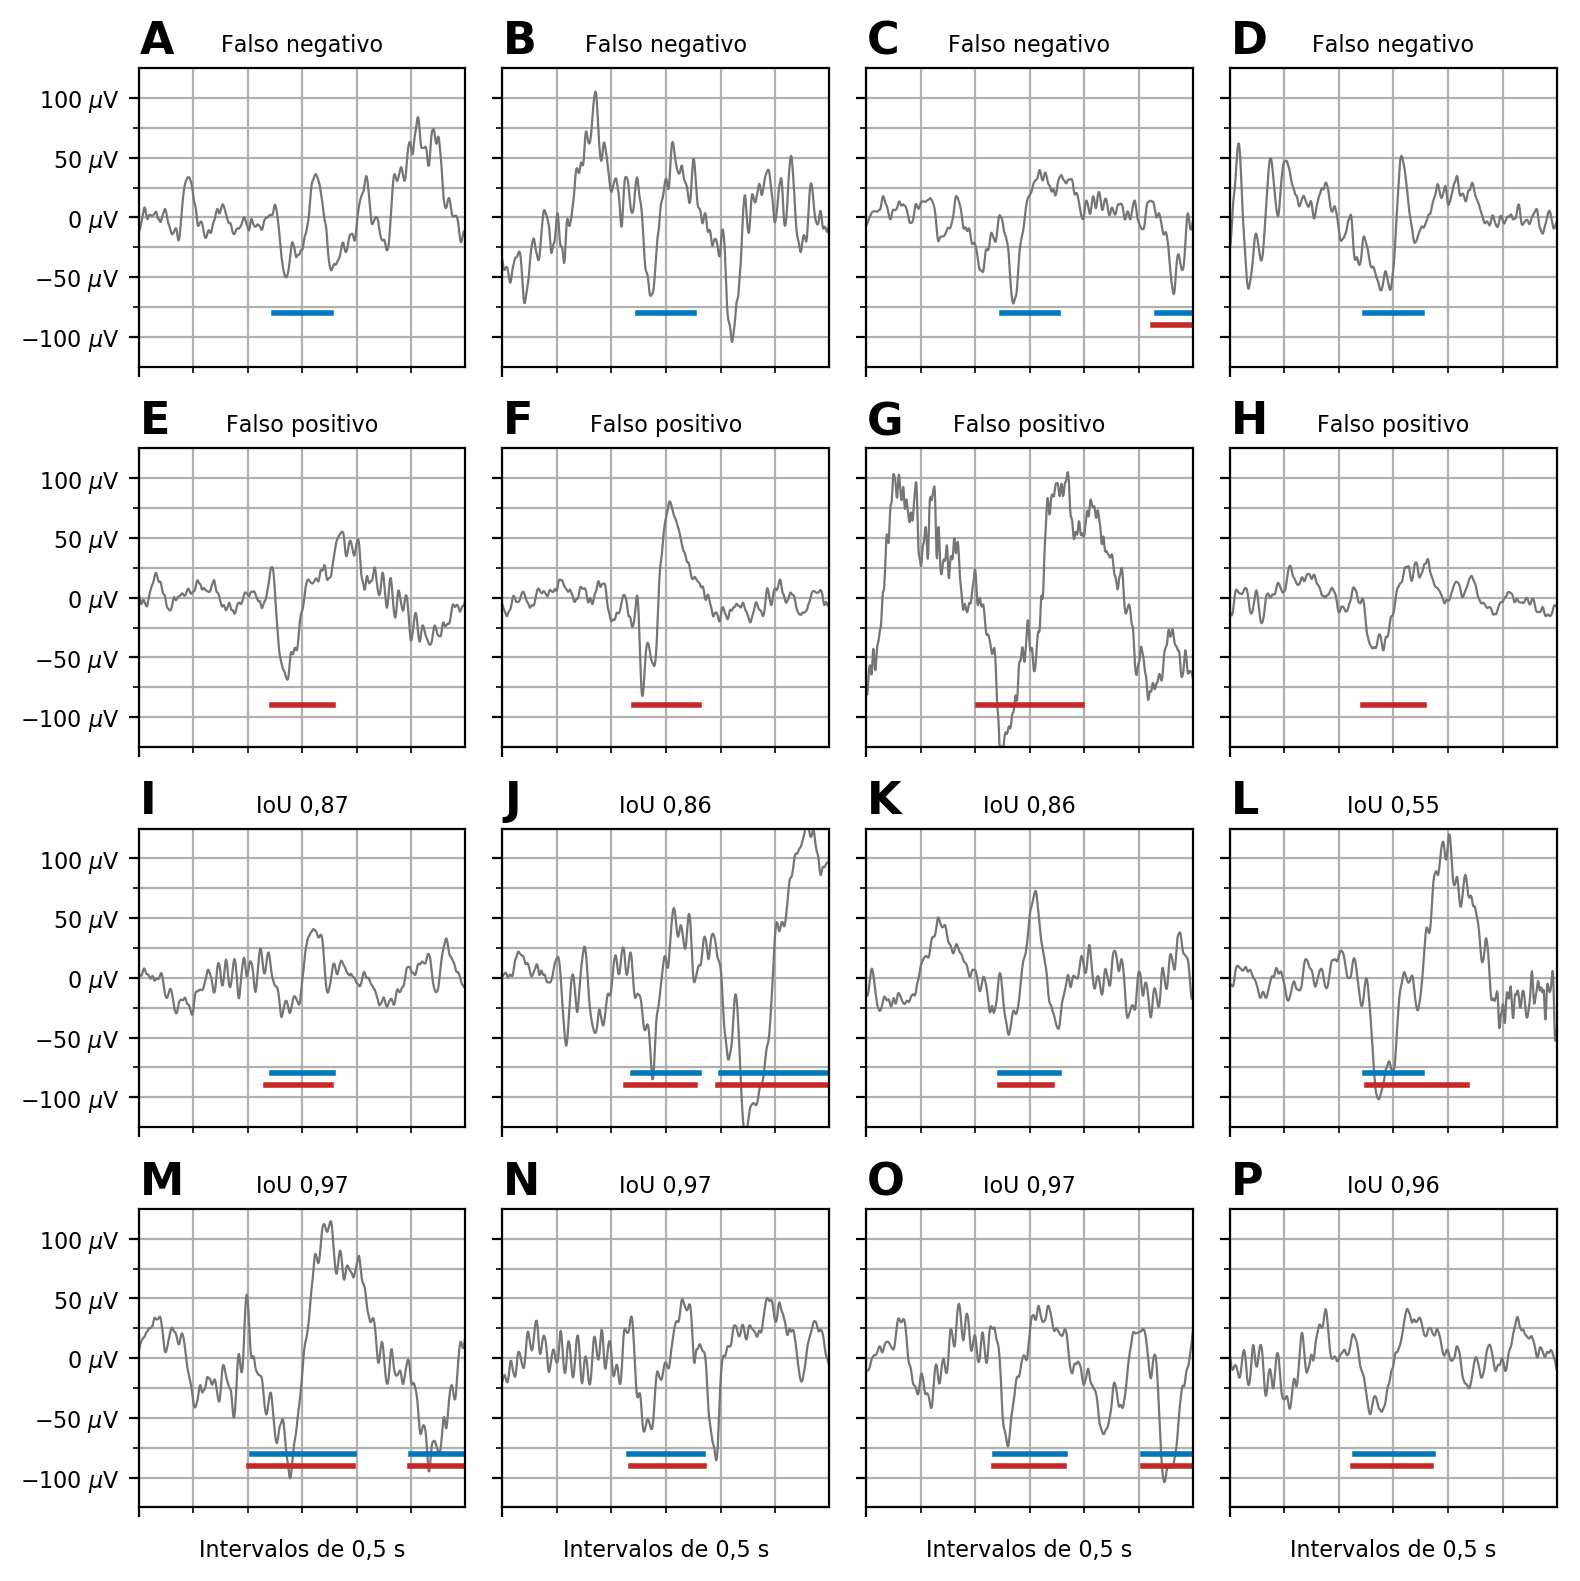

Done


In [65]:
save_figure = True

k = 0
window_duration = 3
y_lim = 100
letters = np.reshape(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'], (4, 4))

for config in eval_configs:
    
    iou_list = []
    
    cases_subject = []
    cases_center = []
    cases_iou = []
    cases_type = []
    
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    window_size = int(dataset.fs * window_duration)
    
    tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
    fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
    fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
    fold_events = dataset.get_subset_stamps(fold_subjects, which_expert=config['expert'], pages_subset='n2')
    
    for subject_id, detections, events in zip(fold_subjects, fold_predictions, fold_events):
        iou_matching, idx_matching = metrics.matching(events, detections)
        
        iou_list.append(iou_matching)
        
        loc_events_fn = np.where(iou_matching==0)[0]
        loc_events_match = np.where(iou_matching>0)[0]
        loc_detections_fp = np.array([i for i in range(len(detections)) if i not in idx_matching])

        if len(loc_events_fn):
            cases_subject.append([subject_id] * len(loc_events_fn))
            cases_iou.append([0] * len(loc_events_fn))
            cases_type.append(['fn'] * len(loc_events_fn))
            cases_center.append(events[loc_events_fn].mean(axis=1))
        if len(loc_detections_fp):
            cases_subject.append([subject_id] * len(loc_detections_fp))
            cases_iou.append([0] * len(loc_detections_fp))
            cases_type.append(['fp'] * len(loc_detections_fp))
            cases_center.append(detections[loc_detections_fp].mean(axis=1))
        if len(loc_events_match):
            cases_subject.append([subject_id] * len(loc_events_match))
            cases_iou.append(iou_matching[loc_events_match])
            cases_type.append(['tp'] * len(loc_events_match))
            cases_center.append(events[loc_events_match].mean(axis=1))
    cases_subject = np.concatenate(cases_subject)
    cases_center = np.concatenate(cases_center)
    cases_iou = np.concatenate(cases_iou)
    cases_type = np.concatenate(cases_type)
    df = pd.DataFrame.from_dict({
        'subject_id': cases_subject,
        'center': cases_center,
        'iou': cases_iou,
        'type': cases_type
    })
    
    df_fn = df[df.type=='fn'].sample(n=4, random_state=1)
    df_fp = df[df.type=='fp'].sample(n=4, random_state=0)
    iou_thr_1, iou_thr_2 = np.percentile(df[df.type=='tp'].iou.values, (25, 75))
    df_iou_low = df[(df.type=='tp') & (df.iou<=iou_thr_1)].sample(n=4, random_state=0)
    df_iou_high = df[(df.type=='tp') & (df.iou>=iou_thr_2)].sample(n=4, random_state=0)
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8), dpi=200, sharex=True, sharey=True)
    for i, df_type in enumerate([df_fn, df_fp, df_iou_low, df_iou_high]):
        for j, event_data in enumerate(df_type.to_dict('records')):
            ax = axes[i, j]
            chosen_subject = event_data['subject_id']
            chosen_center = event_data['center']
            start_sample = int(chosen_center - window_size // 2)
            end_sample = start_sample + window_size
            time_axis = np.arange(0, end_sample - start_sample) / dataset.fs


            # Get signal
            signal = dataset.get_subject_signal(chosen_subject, normalize_clip=False)
            segment_signal = signal[start_sample:end_sample]
            # Get expert annotations
            segment_events = dataset.get_subject_stamps(chosen_subject, which_expert=config['expert'], pages_subset='n2')
            segment_events = utils.filter_stamps(segment_events, start_sample, end_sample) - start_sample
            # Get detections
            segment_dets = tmp_dict[k][constants.TEST_SUBSET].get_subject_stamps(chosen_subject)
            segment_dets = utils.filter_stamps(segment_dets, start_sample, end_sample) - start_sample
            
            # draw signal
            ax.plot(
                time_axis, segment_signal,
                linewidth=0.8,
                color=viz.GREY_COLORS[6])
            for m in segment_events:
                m = np.clip(m, a_min=0, a_max=(end_sample - start_sample))
                ax.plot(m/dataset.fs, [-y_lim * 0.8] * 2, linewidth=2, color=viz.PALETTE['blue'])
            for m in segment_dets:
                m = np.clip(m, a_min=0, a_max=(end_sample - start_sample))
                ax.plot(m/dataset.fs, [-y_lim * 0.9] * 2, linewidth=2, color=viz.PALETTE['red'])
            
            
            # format
            ax.tick_params(labelsize=8)
            if i==0:
                title_str = 'Falso negativo'
            elif i==1:
                title_str = 'Falso positivo'
            elif i==2:
                title_str = 'IoU %s' % ("%1.2f" % event_data['iou']).replace('.',',')
            elif i==3:
                title_str = 'IoU %s' % ("%1.2f" % event_data['iou']).replace('.',',')
            ax.set_title(title_str, fontsize=8)

            t0 = time_axis[0]
            tf = time_axis[-1]
            ax.set_xticks(np.arange(t0, tf + 0.001, 3))
            ax.set_xticks(np.arange(t0, tf + 0.001, 0.5), minor=True)


            ax.set_yticks([-100, -50, 0, 50, 100])
            yticklabels_list = ['$-$100 $\mu$V', '$-$50 $\mu$V', '0 $\mu$V', '50 $\mu$V', '100 $\mu$V']
            ax.set_yticklabels(yticklabels_list)
            ax.set_yticks([-100, -75, -50, -25, 0, 25, 50, 75, 100], minor=True)

            ax.grid(which="minor")
            ax.set_xlim([t0, tf])
            ax.set_ylim([-y_lim-25, y_lim+25])

            if i == 3:
                ax.set_xticklabels([])
                xlabel_str = "Intervalos de 0,5 s"
                ax.set_xlabel(xlabel_str, fontsize=8)
            ax.text(
                x=0, y=1.05, fontsize=16, s=r"$\bf{%s}$" % letters[i, j],
                ha="left", transform=ax.transAxes)

    plt.tight_layout()
    
    if save_figure:
        # Save figure
        fname_prefix = "result_indata_expert_cases_%s" % ('ss' if config["dataset_name"]==constants.MODA_SS_NAME else 'kc')
        plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
        plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
        plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    
    plt.show()
    
print("Done")